# Structured data classification with data from coffea processor

Distinguish `ttgamma` vs. `ttbar`

In [1]:
from coffea import hist, util

import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot
import re

from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
tf.__version__

'2.3.0'

In [3]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self):
        ## Initializer: define outputs.

        # Declare axes
        dataset_axis = hist.Cat("dataset","Dataset")
        
        photon_pt_axis = hist.Bin("pt","photon $p_{T}$ [GeV]", 40, 0, 400)
        photon_eta_axis = hist.Bin("eta","photon $\eta$", 50, -2.5, 2.5)
        photon_phi_axis = hist.Bin("phi","photon $\phi$", 64, -3.2, 3.2)
        photon_reliso_axis = hist.Bin("reliso","photon RelIso", 40, -0.5, 6)
        photon_sieie_axis = hist.Bin("sieie","photon sigma_IetaIeta", 40, 0, 0.05)
        photon_r9_axis = hist.Bin("r9","photon R9", 40, -0.5, 1.5)
        photon_hoe_axis = hist.Bin("hoe","photon H over E", 40, -0.5, 1)
        
        
        # Accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            
            ## column accumulators: a list for each variable to be trained on,
            ## filled when an event passes our selection.
            'photon_pt': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_eta': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_phi': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_reliso': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_sieie': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_r9': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_hoe': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'label': processor.column_accumulator(np.ndarray(shape=(1,1))),
            
            ## histograms for features
            'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis),
            'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis),
            'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis),
            'photon_reliso_hist': hist.Hist("Counts", dataset_axis, photon_reliso_axis),
            'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis),
            'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis),
            'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis),
        }
        )

    @property
    def accumulator(self):
        return self._accumulator

    

    # The process method is where the heart of the analysis is.  
    # This is where all of the selections are done and the histograms get filled 
    #  (things you did in notebook cells before will be done here instead)
    def process(self, events):
        ### The process function is where most of the work happens. As we'll see below, this is
        ### where the main analysis work happens (object cuts, event selections, filling histograms). 
        
        ## This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()

        ## To access variables from the ntuples, use the "events" object
        ## The dataset name is part of events.metadata
        dataset = events.metadata['dataset']

        ## The coffea NanoEventSchema packages all photon variables (columns) into the events.Muon object
        ## Each variable can be accessed using photons.key_name
        
        ######## Select good photons ########
        photons = events.Photon
        photonSelect= ((photons.pt>20) & 
                        (abs(photons.eta) < 1.4442) &
                        (photons.isScEtaEE | photons.isScEtaEB) &
                        (photons.electronVeto) & 
                        np.invert(photons.pixelSeed) 
                       )
        tightPhotons = photons[photonSelect]
        
        ## other objects (for event selection):
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                           (abs(electrons.eta)<2.1) &
                            electrons.cutBased>=4   
                         )
        tightEle = electrons[electronSelectTight]
        
        
        ######## Select good events #########
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        # Select events passing the trigger, with exactly one tight muon, ≥4 jets, ≥ 1 b-tagged jets, and 0 electrons. 
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)==1))

        # Fill the muon_pt histogram using the tightMuons in events that pass our selection 
        # Note that ak.flatten() is required when filling a histogram to remove the jaggedness
        output['photon_pt_hist'].fill(dataset=dataset,
                                      pt=ak.flatten(tightPhotons[eventSelection,:1].pt))
        output['photon_eta_hist'].fill(dataset=dataset,
                                      eta=ak.flatten(tightPhotons[eventSelection,:1].eta))
        output['photon_phi_hist'].fill(dataset=dataset,
                                      phi=ak.flatten(tightPhotons[eventSelection,:1].phi))
        output['photon_reliso_hist'].fill(dataset=dataset,
                                         reliso=ak.flatten(tightPhotons[eventSelection,:1].pfRelIso03_all))
        output['photon_sieie_hist'].fill(dataset=dataset,
                                      sieie=ak.flatten(tightPhotons[eventSelection,:1].sieie))
        output['photon_r9_hist'].fill(dataset=dataset,
                                      r9=ak.flatten(tightPhotons[eventSelection,:1].r9))
        output['photon_hoe_hist'].fill(dataset=dataset,
                                      hoe=ak.flatten(tightPhotons[eventSelection,:1].hoe))
        
        
        # Leading photon
        pt=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.pt[eventSelection,:1],1,clip=True)))
        output['photon_pt']+=pt
        
        eta=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.eta[eventSelection,:1],1,clip=True)))
        output['photon_eta']+=eta
        
        phi=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.phi[eventSelection,:1],1,clip=True)))
        output['photon_phi']+=phi
        
        reliso=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.pfRelIso03_all[eventSelection,:1],1,clip=True)))
        output['photon_reliso']+=reliso
        
        sieie=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.sieie[eventSelection,:1],1,clip=True)))
        output['photon_sieie']+=sieie
        
        r9=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.r9[eventSelection,:1],1,clip=True)))
        output['photon_r9']+=r9
        
        hoe=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.hoe[eventSelection,:1],1,clip=True)))
        output['photon_hoe']+=hoe
        
        
        if dataset=='TTGamma':
            output['label'] += processor.column_accumulator(np.ones_like(ak.to_numpy(ak.pad_none(tightPhotons.pt[eventSelection,:1],1,clip=True))))
        elif dataset=='TTbar':
            output['label'] += processor.column_accumulator(np.zeros_like(ak.to_numpy(ak.pad_none(tightPhotons.pt[eventSelection,:1],1,clip=True))))
        else:
            output['label'] += processor.column_accumulator(2*np.ones_like(ak.to_numpy(ak.pad_none(tightPhotons.pt[eventSelection,:1],1,clip=True))))
        
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
           #"WGamma":[f"{skimDir}/WGamma_2016_skim.root"],
           #"Z+jets":[f'{skimDir}/DYjetsM50_ext2_2016_skim_1of10.root'],
           #"W+3jets":[f"{skimDir}/W3jets_2016_skim.root"],
           #"W+4jets":[f"{skimDir}/W4jets_2016_skim.root"],
          }

#filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
#              }

In [5]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

#Run Coffea code using uproot
outputMC = processor.run_uproot_job(
    fileset,  #dictionary of datasets to run on, defined earlier in this cell
    "Events", #Name of the TTree you will be opening
    PhotonSelector(),  #Coffea processor you defined
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},  ## workers = 2, parallelize jobs, running 2 at once
    chunksize=1000000, #in each chunk, use 1 million events
    #maxchunks=3, #limit to using only 3 chunks for each dataset (useful for testing purposes)
)

Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

In [6]:
'''
outputData = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
)
'''

'outputData = processor.run_uproot_job(\n    filesetData,\n    "Events",\n    PhotonSelector(),\n    processor.futures_executor,\n    executor_args={"schema": SkimmedSchema,\'workers\': 4},\n    chunksize=1000000,\n)\n'

In [7]:
'''
nEvents = {}
for d in fileset:
    if not d in nEvents:
        nEvents[d] = 0
    for fName in fileset[d]:
        with uproot.open(fName)['hEvents'] as hEvents:
            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]
cx = {'TTGamma':7.509,
     'TTbar': 380.095,
     'WGamma':489,
     'Z+jets':6077.22,
     'W+3jets':1165.8108,
     'W+4jets':592.9176}
lumi_weight = {}
for keyName in fileset:
    lumi_weight[keyName] = (cx[keyName]*450.)/nEvents[keyName]
    
for key, obj in outputMC.items():
    if isinstance(obj, hist.Hist):
        obj.scale(lumi_weight, axis="dataset")
'''

'\nnEvents = {}\nfor d in fileset:\n    if not d in nEvents:\n        nEvents[d] = 0\n    for fName in fileset[d]:\n        with uproot.open(fName)[\'hEvents\'] as hEvents:\n            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]\ncx = {\'TTGamma\':7.509,\n     \'TTbar\': 380.095,\n     \'WGamma\':489,\n     \'Z+jets\':6077.22,\n     \'W+3jets\':1165.8108,\n     \'W+4jets\':592.9176}\nlumi_weight = {}\nfor keyName in fileset:\n    lumi_weight[keyName] = (cx[keyName]*450.)/nEvents[keyName]\n    \nfor key, obj in outputMC.items():\n    if isinstance(obj, hist.Hist):\n        obj.scale(lumi_weight, axis="dataset")\n'

In [8]:
'''
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
}
'''

"\ndata_err_opts = {\n    'linestyle':'none',\n    'marker': '.',\n    'markersize': 10.,\n    'color':'k',\n    'elinewidth': 1,\n}\n"

<AxesSubplot:xlabel='photon $p_{T}$ [GeV]', ylabel='Counts'>

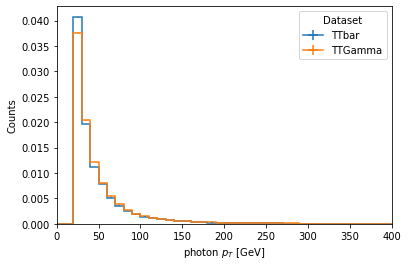

In [9]:
#### Histograms ###

hist.plot1d(outputMC['photon_pt_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon $\\eta$', ylabel='Counts'>

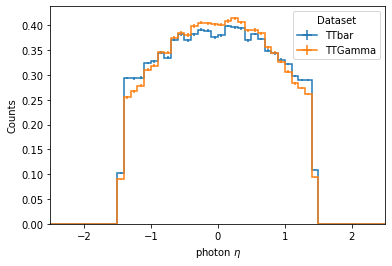

In [10]:
hist.plot1d(outputMC['photon_eta_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon $\\phi$', ylabel='Counts'>

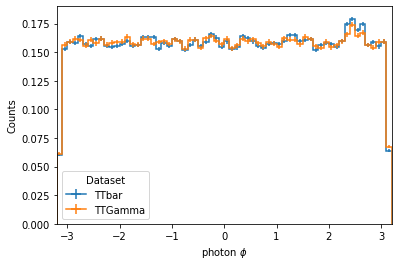

In [11]:
hist.plot1d(outputMC['photon_phi_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon RelIso', ylabel='Counts'>

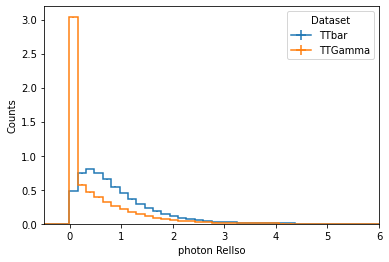

In [12]:
hist.plot1d(outputMC['photon_reliso_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon sigma_IetaIeta', ylabel='Counts'>

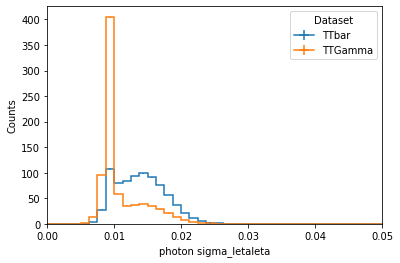

In [13]:
hist.plot1d(outputMC['photon_sieie_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon R9', ylabel='Counts'>

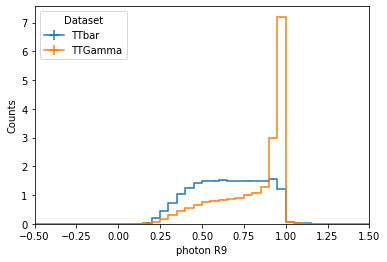

In [14]:
hist.plot1d(outputMC['photon_r9_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon H over E', ylabel='Counts'>

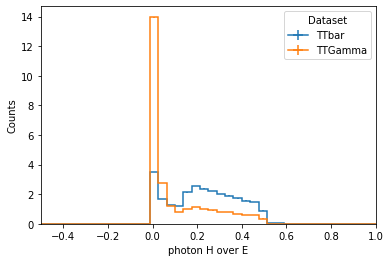

In [15]:
hist.plot1d(outputMC['photon_hoe_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

In [16]:
#### Column accumulators ####

In [17]:
outputMC['photon_pt'].value.shape

(855579, 1)

In [18]:
outputMC['photon_pt']

column_accumulator(masked_array(
  data=[[31.75030708],
        [21.61360741],
        [23.44291878],
        ...,
        [50.53926086],
        [38.89995193],
        [20.48979759]],
  mask=False,
  fill_value=1e+20))

In [19]:
outputMC['photon_eta']

column_accumulator(masked_array(
  data=[[-0.71582031],
        [ 1.01953125],
        [ 0.79907227],
        ...,
        [ 0.76745605],
        [ 0.38262939],
        [-1.24365234]],
  mask=False,
  fill_value=1e+20))

In [20]:
outputMC['photon_phi']

column_accumulator(masked_array(
  data=[[-0.64953613],
        [-2.38769531],
        [ 2.75097656],
        ...,
        [-2.48242188],
        [-0.27545166],
        [-1.12719727]],
  mask=False,
  fill_value=1e+20))

In [21]:
outputMC['label'] # is [everything else=2], [TTbar=0], [TTGamma=1] the right order?

column_accumulator(masked_array(
  data=[[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],
  mask=False,
  fill_value=1e+20))

## Preprocessing

In [32]:
## normalize z-score: mean = 0, stdev = 1

scaler = StandardScaler() # from scikit learn

feature_array = np.transpose(np.array([
    np.array(outputMC['photon_pt'].value)[:,0],
    np.array(outputMC['photon_eta'].value)[:,0],
    np.array(outputMC['photon_phi'].value)[:,0],
    np.array(outputMC['photon_reliso'].value)[:,0],
    np.array(outputMC['photon_sieie'].value)[:,0],
    np.array(outputMC['photon_r9'].value)[:,0],
    np.array(outputMC['photon_hoe'].value)[:,0]
]))

scaler.fit(feature_array)
scaled_feature_array = scaler.transform(feature_array)
scaled_feature_array

array([[-0.4092317 , -0.92111717, -0.36464334, ...,  2.14429822,
        -2.09175175, -0.2590582 ],
       [-0.65913058,  1.29955658, -1.32203159, ..., -0.07494946,
         0.3325147 , -1.07888376],
       [-0.61403278,  1.01744228,  1.50837896, ...,  0.97477703,
         0.71526683, -0.35283898],
       ...,
       [ 0.05397019,  0.97698403, -1.37420754, ..., -1.260714  ,
        -0.10927898, -1.07888376],
       [-0.23297234,  0.48453369, -0.15859542, ..., -0.68001424,
         1.0389774 , -1.07888376],
       [-0.68683574, -1.5965669 , -0.62774189, ..., -0.89320821,
        -0.25382898,  0.89353788]])

In [33]:
# add target column
data_array = np.append(scaled_feature_array, np.array(outputMC['label'].value), 1)
data_array

array([[-0.4092317 , -0.92111717, -0.36464334, ..., -2.09175175,
        -0.2590582 ,  0.        ],
       [-0.65913058,  1.29955658, -1.32203159, ...,  0.3325147 ,
        -1.07888376,  0.        ],
       [-0.61403278,  1.01744228,  1.50837896, ...,  0.71526683,
        -0.35283898,  0.        ],
       ...,
       [ 0.05397019,  0.97698403, -1.37420754, ..., -0.10927898,
        -1.07888376,  1.        ],
       [-0.23297234,  0.48453369, -0.15859542, ...,  1.0389774 ,
        -1.07888376,  1.        ],
       [-0.68683574, -1.5965669 , -0.62774189, ..., -0.25382898,
         0.89353788,  1.        ]])

In [34]:
## numpy data array --> pandas dataframe ##
df = pd.DataFrame({
        'pt': data_array[:,0],
        'eta': data_array[:,1],
        'phi': data_array[:,2],
        'reliso': data_array[:,3],
        'sieie': data_array[:,4],
        'r9': data_array[:,5],
        'hoe': data_array[:,6],
        'target': data_array[:,7]
})
val_df = df.sample(frac=0.1, random_state=1337) # 10% validation
train_df = df.drop(val_df.index)                # 90% training


## pandas dataframe --> tensorflow dataset ##
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) # dataset object
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_df)


## batch the datasets ##
train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

In [35]:
val_df

,pt,eta,phi,reliso,sieie,r9,hoe,target
310209,0.155137,1.592918,-1.645038,0.570805,-0.355147,0.908679,1.311014,0.0
289450,4.891628,-0.627209,0.144039,-0.334361,0.000176,-1.522204,-0.342251,0.0
255702,-0.420119,-1.379748,-1.197240,0.392957,3.265089,-1.234122,1.788993,0.0
99474,-0.164674,-0.792088,-0.771091,-0.305480,-0.730775,-0.378020,0.294551,0.0
72634,-0.631786,1.021348,1.436570,1.113320,1.965621,1.093947,-1.078884,0.0
...,...,...,...,...,...,...,...,...
715249,-0.524856,1.735693,-0.346489,-0.457133,-0.795748,0.831314,-0.950313,1.0
244493,-0.291462,1.790367,-0.246205,-0.282390,-0.089162,-1.229033,1.680086,0.0
849658,10.655534,-0.590422,1.577768,-0.888277,-0.913512,0.965684,-1.028023,1.0
795447,0.014035,1.134912,0.840850,-0.894465,-0.811991,0.986044,-1.078884,1.0


In [36]:
print(np.mean(df.pt)) # ~0
print(np.std(df.pt))  # ~1

-1.3752777597611979e-17
1.0


In [41]:
# define the model
all_inputs = [
        keras.Input(shape=(1,), name='pt'),
        keras.Input(shape=(1,), name='eta'),
        keras.Input(shape=(1,), name='phi'),
        keras.Input(shape=(1,), name='reliso'),
        keras.Input(shape=(1,), name='sieie'),
        keras.Input(shape=(1,), name='r9'),
        keras.Input(shape=(1,), name='hoe')
]

all_features = layers.concatenate(all_inputs)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [42]:
# train the model on our dataset
model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
6016/6016 [==============================] - 25s 4ms/step - loss: 0.4909 - accuracy: 0.7846 - val_loss: 0.4824 - val_accuracy: 0.7897
Epoch 2/5
6016/6016 [==============================] - 25s 4ms/step - loss: 0.4831 - accuracy: 0.7895 - val_loss: 0.4813 - val_accuracy: 0.7907
Epoch 3/5
6016/6016 [==============================] - 27s 4ms/step - loss: 0.4819 - accuracy: 0.7900 - val_loss: 0.4824 - val_accuracy: 0.7908
Epoch 4/5
6016/6016 [==============================] - 26s 4ms/step - loss: 0.4814 - accuracy: 0.7905 - val_loss: 0.4834 - val_accuracy: 0.7902
Epoch 5/5
6016/6016 [==============================] - 24s 4ms/step - loss: 0.4810 - accuracy: 0.7906 - val_loss: 0.4804 - val_accuracy: 0.7912
